In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/MultizoneBeamCombining/FirstAttempt/'
lam = 0.8
tau = 35.

In [2]:
pulseParams = {
    'Nt' : 2**6,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
}
pulseNx = 2**11
pulseNy = 2**11
pulseX = 3e4
pulseY = 3e4

beamNx = 2**12
beamNy = 2**12
beamX = 6e4
beamY = 6e4

plasmaParams = {
    'Nx' : pulseNx,
    'Ny' : pulseNy,
    'Nz' : 2**8,
    'X' : pulseX,
    'Y' : pulseY,
    'Z' : 2.0e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

In [3]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 2.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.50, zf)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(z/1e6, I)
plt.title('Intensity profile')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'I ($10^{14}W/cm^2$)')
plt.xlim([0, 4]);

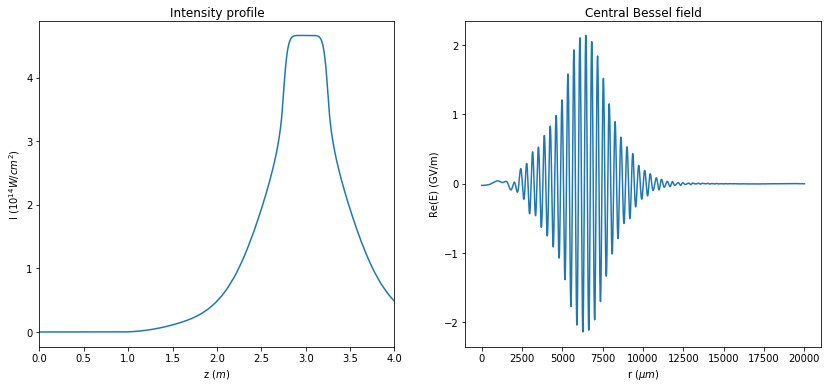

In [4]:
# Create the input field for the central mode with the ramps
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 140,
    'lam' : lam
}
rJ0, EJ0 = bessel.bessel_expansion(params, z, I)
plt.subplot(122)
plt.plot(rJ0, EJ0.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

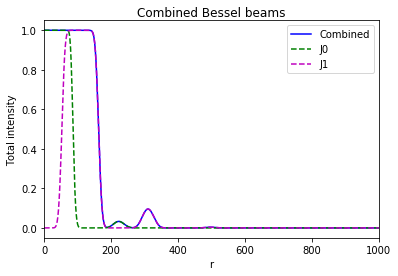

In [5]:
# Determine the strength of the first order mode
coef = [0.5, 0.9]
order = [0, 1]
R = [140, 140] #140 to limit refraction
r = np.linspace(0, 1e3, 1000)
ne, nj = bessel.multimode_transverse_estimate(r, ion, coef, order, R)
plt.plot(r, ne, 'b', r, nj[0, :], 'g--', r, nj[1, :], 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J0', 'J1'])
plt.xlim([0, 1000])
plt.show()

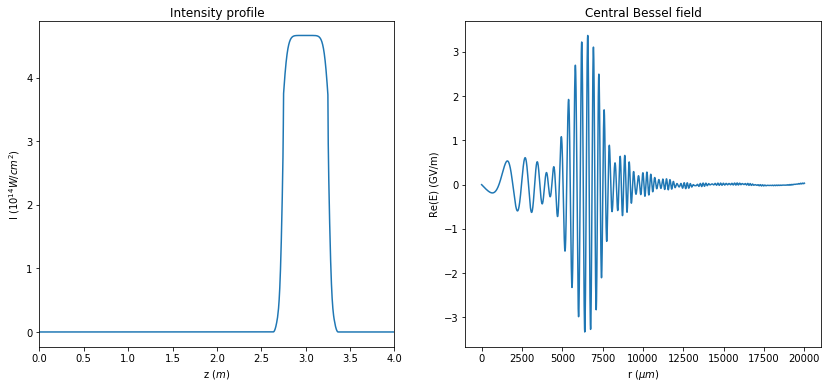

In [6]:
# Create the intensity profile with short ramps
sigmaIn = 1e4
sigmaOut = 1e4
z1, I1 = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.50, zf)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(z1/1e6, I1)
plt.title('Intensity profile')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'I ($10^{14}W/cm^2$)')
plt.xlim([0, 4])
# Create the input field for the first order on the second lens
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : R[1],
    'lam' : lam
}
rJ1, EJ1 = bessel.bessel_expansion(params, z1, I1, order[1])
EJ1 += coef[1]*EJ1
plt.subplot(122)
plt.plot(rJ1, EJ1.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

Power: 1.12048312078


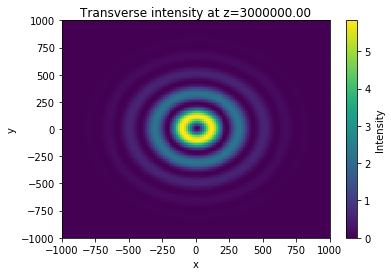

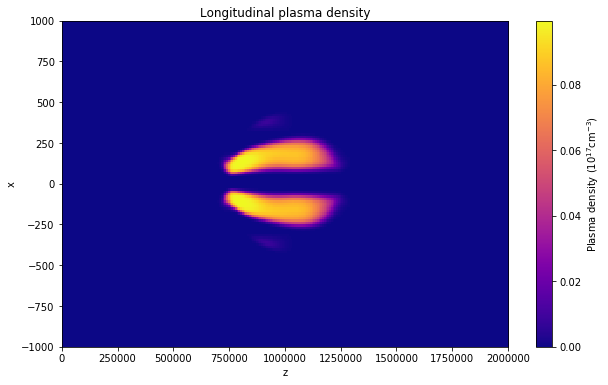

In [7]:
# Calculate the plasma density for the first order mode
multiJ1 = 1.0
pulseParams['name'] = 'J1Beam'
pulseParams['order'] = order[1]
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rJ1
pulseParams['E'] = multiJ1 * EJ1
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'J1Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
beam.propagate(1.0e6, 1.0) # test to make sure the beam looks correct
beam.plot_current_intensity(lim=[-1000, 1000])
plasmaParams['name'] = 'Plasma1'
argon = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

Power: 0.763742498238


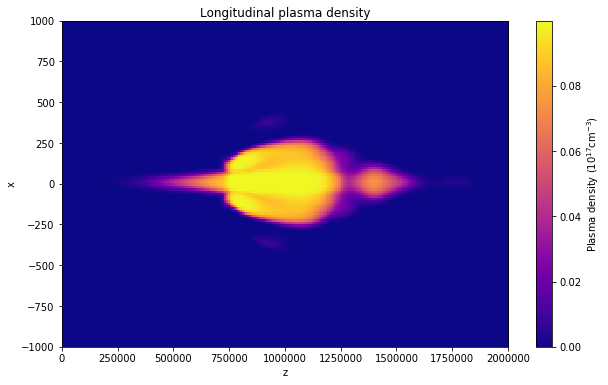

In [8]:
# Calculate the plasma density for the central mode
multiJ0 = 1.1
pulseParams['name'] = 'J0Beam'
pulseParams['order'] = 0
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rJ0
pulseParams['E'] = multiJ0 * EJ0
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'J0Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'Plasma1'
plasmaParams['name'] = 'Plasma0'
argon = plasma.ExistingPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

In [9]:
# First we calculate the radius and angle for each higher order mode. 
z00 = 2.75e6
zfinal = 3.25e6
N = 16
theta = np.zeros(N, dtype='double')
radius = np.zeros(N, dtype='double')
radius[0] = 12500
theta[0] = radius[0]/zfinal
for i in range(1, N):
    theta[i] = theta[0]*(zfinal/z00)**i
    radius[i] = zfinal*theta[i]
print('Outer radius on lens:', radius/1e4)
width = 2.4048*lam/(2*np.pi*theta)
print('Mode width:', 2.4048*lam/(2*np.pi*theta))

Outer radius on lens: [  1.25         1.47727273   1.74586777   2.06329827   2.43844341
   2.88179676   3.40575981   4.02498886   4.75680502   5.62167866
   6.64380205   7.85176606   9.27935989  10.96651624  12.96042828
  15.31686978]
Mode width: [ 79.60904789  67.36150206  56.99819405  48.22924112  40.80935787
  34.53099512  29.21853433  24.7233752   20.91977902  17.70135148
  14.97806664  12.67374869  10.7239412    9.07410409   7.67808808
   6.49684376]


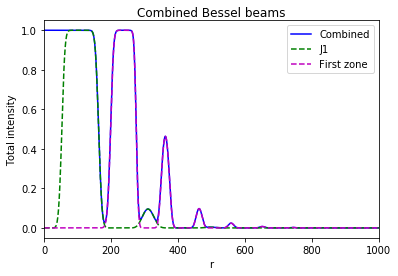

In [65]:
# Determine the strength of the first multizone mode
coef = [0.5, 0.9, 2.2]
order = [0, 1, 7]
R = [140, 140, width[1]]
r = np.linspace(0, 1e3, 1000)
ne, nj = bessel.multimode_transverse_estimate(r, ion, coef, order, R)
plt.plot(r, ne, 'b', r, nj[1, :], 'g--', r, nj[2, :], 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J1', 'First zone'])
plt.xlim([0, 1000])
plt.show()

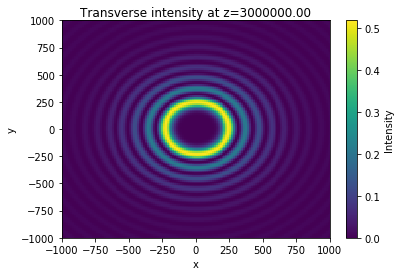

19.6380322563
57.3532656271


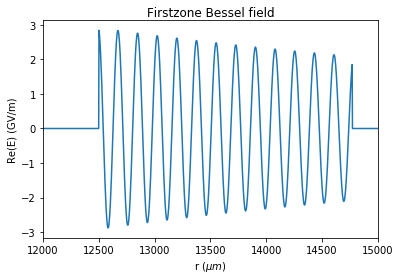

In [66]:
# Create the input field for the first multizone
from scipy.special import jn
rZ1 = np.linspace(0, 3e4, 10000)
EZ1 = np.zeros(10000, dtype='complex128')
sel = (rZ1 < radius[1]) * (rZ1 > radius[0])
EZ1[sel] = radius[0]**2/rZ1[sel]**2
EZ1 *= np.exp(-1j*theta[1]*2*np.pi/lam*rZ1)
pulseParams['name'] = 'Z1Beam'
pulseParams['order'] = order[2]
pulseParams['r'] = rZ1
pulseParams['E'] = EZ1
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
beam = laserbeam.RadialLaser(pulseParams)
beam.propagate(3e6, 1.0)
beam.plot_current_intensity(lim=[-1000, 1000])
Ebeam = np.amax(abs(beam.load_field(1)[0]))
print(Ebeam)
k = 2.4048/R[2]
ENorm = ionization.field_from_intensity(ionization.intensity_from_density(ion, 0.999))
Ebess = np.amax(abs(ENorm*(1+coef[2])*jn(order[2], k*rZ1)))
print(Ebess)
EZ1 = (Ebess/Ebeam) * EZ1

plt.plot(rZ1, EZ1.real)
plt.title('First zone Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.xlim([12e3, 15e3])
plt.show()

Power: 2.45812046996


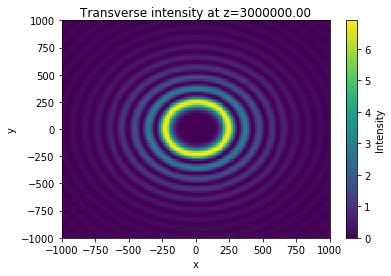

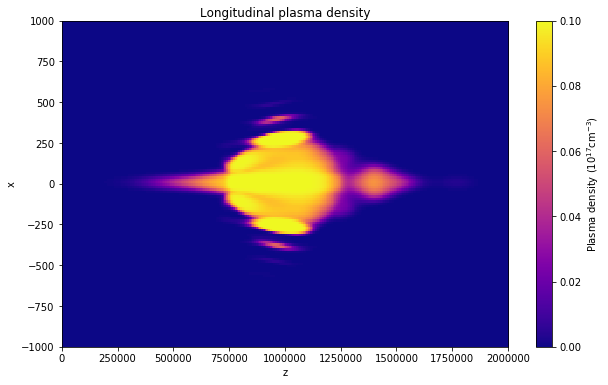

In [69]:
# Calculate the plasma density for the first order mode
multiZ1 = 1.25
pulseParams['name'] = 'Z1Beam'
pulseParams['order'] = order[2]
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rZ1
pulseParams['E'] = multiZ1 * EZ1
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'Z1Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
beam.propagate(1.0e6, 1.0) # test to make sure the beam looks correct
beam.plot_current_intensity(lim=[-1000, 1000])
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'Plasma0'
plasmaParams['name'] = 'PlasmaZ1'
argon = plasma.ExistingPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

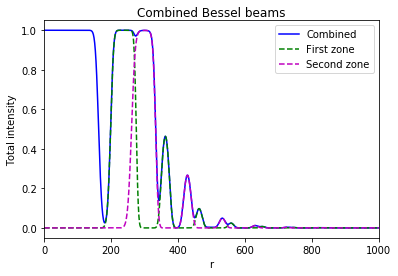

In [71]:
# Determine the strength of the first multizone mode
coef = [0.5, 0.9, 2.2, 2.2]
order = [0, 1, 7, 9]
R = [140, 140, width[1], width[1]]
r = np.linspace(0, 1e3, 1000)
ne, nj = bessel.multimode_transverse_estimate(r, ion, coef, order, R)
plt.plot(r, ne, 'b', r, nj[2, :], 'g--', r, nj[3, :], 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'First zone', 'Second zone'])
plt.xlim([0, 1000])
plt.show()

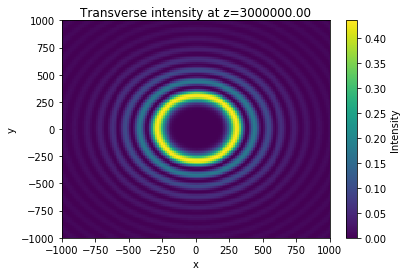

17.9887147613
53.0892233022


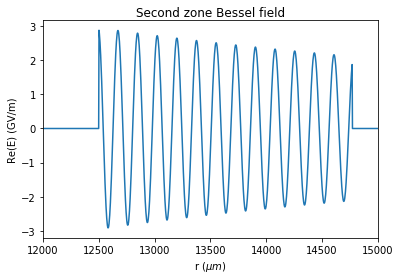

In [72]:
# Create the input field for the first multizone
from scipy.special import jn
rZ2 = np.linspace(0, 3e4, 10000)
EZ2 = np.zeros(10000, dtype='complex128')
sel = (rZ2 < radius[1]) * (rZ2 > radius[0])
EZ2[sel] = radius[0]**2/rZ2[sel]**2
EZ2 *= np.exp(-1j*theta[1]*2*np.pi/lam*rZ2)
pulseParams['name'] = 'Z2Beam'
pulseParams['order'] = order[3]
pulseParams['r'] = rZ2
pulseParams['E'] = EZ2
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
beam = laserbeam.RadialLaser(pulseParams)
beam.propagate(3e6, 1.0)
beam.plot_current_intensity(lim=[-1000, 1000])
Ebeam = np.amax(abs(beam.load_field(1)[0]))
print(Ebeam)
k = 2.4048/R[3]
ENorm = ionization.field_from_intensity(ionization.intensity_from_density(ion, 0.999))
Ebess = np.amax(abs(ENorm*(1+coef[3])*jn(order[3], k*rZ2)))
print(Ebess)
EZ2 = (Ebess/Ebeam) * EZ2

plt.plot(rZ2, EZ2.real)
plt.title('Second zone Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.xlim([12e3, 15e3])
plt.show()

Power: 2.51012455154


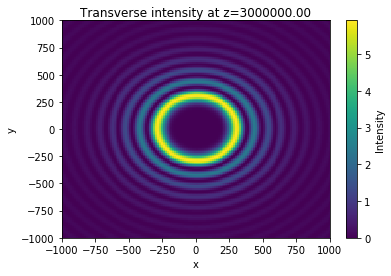

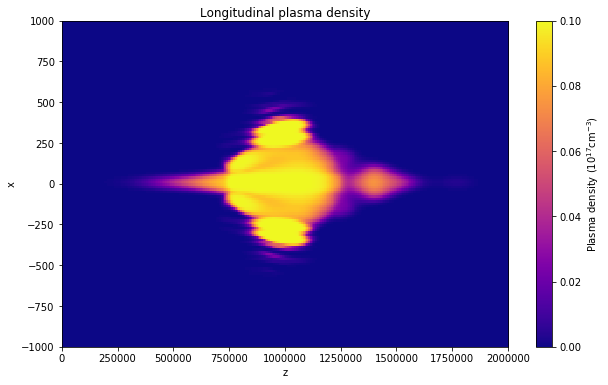

In [74]:
# Calculate the plasma density for the first order mode
multiZ2 = 1.25
pulseParams['name'] = 'Z2Beam'
pulseParams['order'] = order[3]
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rZ2
pulseParams['E'] = multiZ2 * EZ2
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'Z2Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
beam.propagate(1.0e6, 1.0) # test to make sure the beam looks correct
beam.plot_current_intensity(lim=[-1000, 1000])
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'PlasmaZ1'
plasmaParams['name'] = 'PlasmaZ2'
argon = plasma.ExistingPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

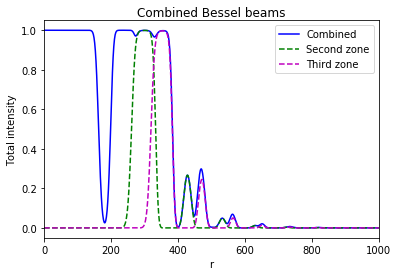

In [79]:
# Determine the strength of the first multizone mode
coef = [0.5, 0.9, 2.2, 2.2, 2.5]
order = [0, 1, 7, 9, 13]
R = [140, 140, width[1], width[1], width[2]]
r = np.linspace(0, 1e3, 1000)
ne, nj = bessel.multimode_transverse_estimate(r, ion, coef, order, R)
plt.plot(r, ne, 'b', r, nj[3, :], 'g--', r, nj[4, :], 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'Second zone', 'Third zone'])
plt.xlim([0, 1000])
plt.show()

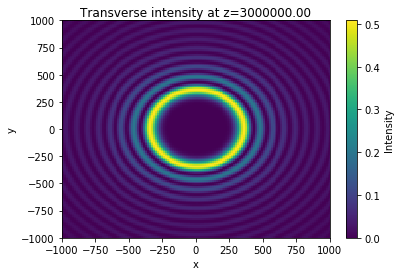

19.5650026463
51.7703163759


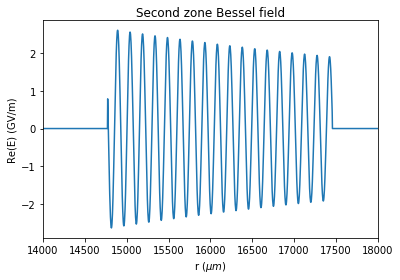

In [81]:
# Create the input field for the first multizone
from scipy.special import jn
rZ3 = np.linspace(0, 3e4, 10000)
EZ3 = np.zeros(10000, dtype='complex128')
sel = (rZ3 < radius[2]) * (rZ2 > radius[1])
EZ3[sel] = radius[1]**2/rZ3[sel]**2
EZ3 *= np.exp(-1j*theta[2]*2*np.pi/lam*rZ3)
pulseParams['name'] = 'Z3Beam'
pulseParams['order'] = order[4]
pulseParams['r'] = rZ3
pulseParams['E'] = EZ3
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
beam = laserbeam.RadialLaser(pulseParams)
beam.propagate(3e6, 1.0)
beam.plot_current_intensity(lim=[-1000, 1000])
Ebeam = np.amax(abs(beam.load_field(1)[0]))
print(Ebeam)
k = 2.4048/R[4]
ENorm = ionization.field_from_intensity(ionization.intensity_from_density(ion, 0.999))
Ebess = np.amax(abs(ENorm*(1+coef[4])*jn(order[4], k*rZ2)))
print(Ebess)
EZ3 = (Ebess/Ebeam) * EZ3

plt.plot(rZ3, EZ3.real)
plt.title('Second zone Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.xlim([14e3, 18e3])
plt.show()

Power: 2.81548225184


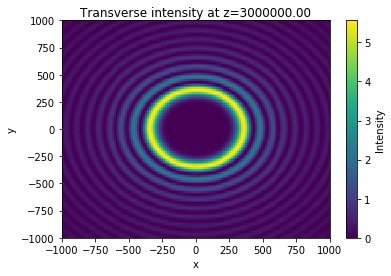

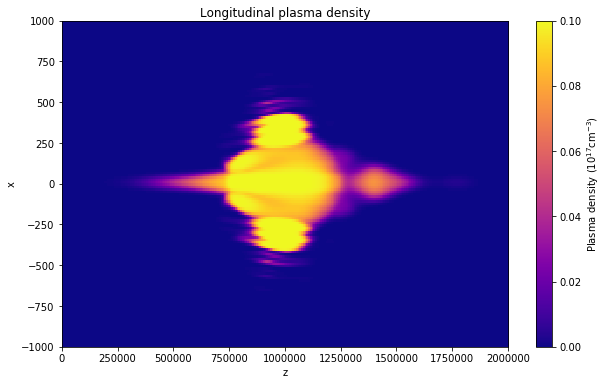

In [82]:
# Calculate the plasma density for the first order mode
multiZ3 = 1.25
pulseParams['name'] = 'Z3Beam'
pulseParams['order'] = order[4]
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rZ3
pulseParams['E'] = multiZ3 * EZ3
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'Z3Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
beam.propagate(1.0e6, 1.0) # test to make sure the beam looks correct
beam.plot_current_intensity(lim=[-1000, 1000])
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'PlasmaZ2'
plasmaParams['name'] = 'PlasmaZ3'
argon = plasma.ExistingPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

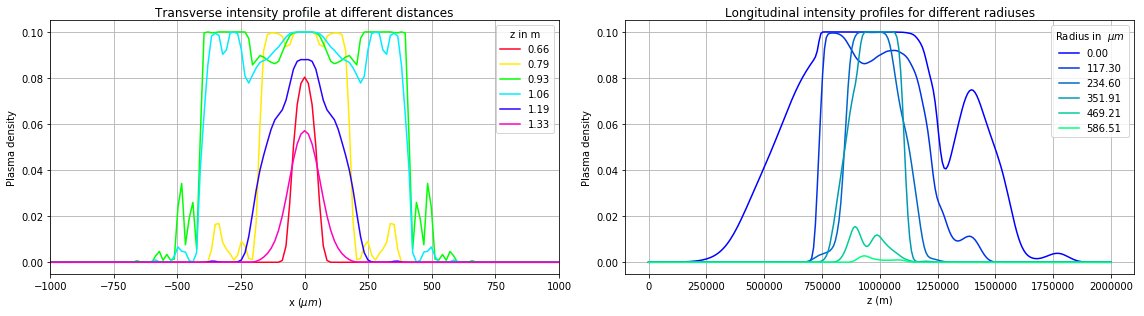

In [84]:
argon.plot_profiles(6, 100, xlim=[-1e3, 1e3])